In [1]:
# modelling potential:

# df_activity: medium but dataset too small
# df_weight: low
# df_sec: aggregate to 1/5/15 min interval
# df_min: intensity?
# df_hr: lifestyle trends

### Contents

- [EDA](#EDA)

### Header

In [2]:
# user configuration

In [3]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydotplus

# modelling
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score,r2_score,mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.externals.six import StringIO 

# Others
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Import Data

In [4]:
# file paths

input_path = '../data/1_input/'
clean_path = '../data/2_clean/'
preprocess_path = '../data/3_preprocess/'
output_path = '../data/4_output/'

folders = ['Fitabase Data 3.12.16-4.11.16','Fitabase Data 4.12.16-5.12.16']

In [5]:
# import clean data

df_activity = pd.read_csv(clean_path + 'activity.csv')
df_weight = pd.read_csv(clean_path + 'weight.csv')

df_sec = pd.read_csv(clean_path + 'seconds.csv')
df_min = pd.read_csv(clean_path + 'minutes.csv')
df_hr = pd.read_csv(clean_path + 'hours.csv')

### Functions

### Data Overview

In [6]:
print(df_activity.shape)
df_activity.head()

(457, 17)


,id,timestamp,dayweek,year,month,day,steps,calories,dist_total,dist_act_high,dist_act_med,dist_act_low,dist_act_sede,mins_act_high,mins_act_med,mins_act_low,mins_act_sede
0,1,2016-03-25,Friday,2016,3,25,11004,1819,7.10,2.57,0.46,4.07,0.0,33,12,205,804
1,1,2016-03-26,Saturday,2016,3,26,17609,2154,11.56,6.92,0.73,3.91,0.0,89,17,274,588
2,1,2016-03-27,Sunday,2016,3,27,12736,1944,8.53,4.66,0.16,3.71,0.0,56,5,268,605
3,1,2016-03-28,Monday,2016,3,28,13231,1932,8.93,3.19,0.79,4.95,0.0,39,20,224,1080
4,1,2016-03-29,Tuesday,2016,3,29,12041,1886,7.86,2.16,1.09,4.61,0.0,28,28,243,763


In [7]:
df_activity.columns

Index(['id', 'timestamp', 'dayweek', 'year', 'month', 'day', 'steps',
       'calories', 'dist_total', 'dist_act_high', 'dist_act_med',
       'dist_act_low', 'dist_act_sede', 'mins_act_high', 'mins_act_med',
       'mins_act_low', 'mins_act_sede'],
      dtype='object')

In [8]:
#print(stop)

### Preprocess Data

In [9]:
df_activity['mins_total'] = df_activity['mins_act_high'] + df_activity['mins_act_med'] + df_activity['mins_act_low'] + df_activity['mins_act_sede']

df_activity['mins_pct_high'] = df_activity['mins_act_high'] / df_activity['mins_total']
df_activity['mins_pct_med'] = df_activity['mins_act_med'] / df_activity['mins_total']
df_activity['mins_pct_low'] = df_activity['mins_act_low'] / df_activity['mins_total']
df_activity['mins_pct_sede'] = df_activity['mins_act_sede'] / df_activity['mins_total']

cols = ['mins_total','mins_act_high','mins_act_med', 'mins_act_low','mins_act_sede']
df_activity.drop(columns=cols,inplace=True)

In [10]:
mask_steps = df_activity['steps'] >= 1000
df_activity_2 = df_activity[mask_steps]

In [11]:
cols = ['timestamp','year','month', 'day']
df_activity_2.drop(columns=cols,inplace=True)

In [12]:
df_activity_2 = pd.get_dummies(df_activity_2,columns=['dayweek'],drop_first=True)

print(df_activity_2.shape)
df_activity_2.head()

(370, 18)


,id,steps,calories,dist_total,dist_act_high,dist_act_med,dist_act_low,dist_act_sede,mins_pct_high,mins_pct_med,mins_pct_low,mins_pct_sede,dayweek_Monday,dayweek_Saturday,dayweek_Sunday,dayweek_Thursday,dayweek_Tuesday,dayweek_Wednesday
0,1,11004,1819,7.10,2.57,0.46,4.07,0.0,0.031309,0.011385,0.194497,0.762808,0,0,0,0,0,0
1,1,17609,2154,11.56,6.92,0.73,3.91,0.0,0.091942,0.017562,0.283058,0.607438,0,1,0,0,0,0
2,1,12736,1944,8.53,4.66,0.16,3.71,0.0,0.059957,0.005353,0.286938,0.647752,0,0,1,0,0,0
3,1,13231,1932,8.93,3.19,0.79,4.95,0.0,0.028613,0.014674,0.164343,0.792370,1,0,0,0,0,0
4,1,12041,1886,7.86,2.16,1.09,4.61,0.0,0.026365,0.026365,0.228814,0.718456,0,0,0,0,1,0


### Create Features and Target

In [13]:
target = 'id'
features = [x for x in df_activity_2.columns if x != target]

X = df_activity_2[features].values
y = df_activity_2[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,stratify=y,random_state=3050)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(259, 17)
(111, 17)
(259,)
(111,)


In [15]:
#scale_idx = 11

scale_idx = 8 
#scale_idx = 12

ss = StandardScaler()
ss.fit(X_train[:,:scale_idx])

X_train_scale = ss.transform(X_train[:,:scale_idx])
X_test_scale = ss.transform(X_test[:,:scale_idx])

X_train[:,:scale_idx] = X_train_scale
X_test[:,:scale_idx] = X_test_scale

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_train_scale.shape)
print(X_test_scale.shape)

(259, 17)
(111, 17)
(259, 8)
(111, 8)


### Logistic Regression Model

In [17]:
# init model

logreg = LogisticRegression()

In [18]:
# perform cross validation

score = cross_val_score(logreg,X,y,cv=5)
mse = cross_val_score(logreg,X,y,cv=5,scoring='neg_mean_squared_error')
r2 = cross_val_score(logreg,X,y,cv=5,scoring='r2')

print('score:',score.mean(),score)
print('mse:',mse.mean(),mse)
print('r2:',r2.mean(),r2)

score: 0.30712121212121213 [0.29545455 0.25       0.29166667 0.34848485 0.35      ]
mse: -131.7150937950938 [-127.29545455 -123.23809524 -119.30555556 -149.13636364 -139.6       ]
r2: -0.2511930522125164 [-0.21953682 -0.156445   -0.10327998 -0.45112134 -0.32558213]


In [19]:
# fit model

logreg.fit(X_train, y_train)

# score model
print("train r2:",logreg.score(X_train, y_train))
print("test r2:",logreg.score(X_test, y_test))

# validate model
y_pred = logreg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("rmse:",rmse)

train r2: 0.4942084942084942
test r2: 0.25225225225225223
rmse: 12.261784183035981


In [20]:
cols = ['y_test']
df_result = pd.DataFrame(y_test,columns=cols)

df_result['y_pred'] = y_pred
df_result['result'] = False

for idx,row in df_result.iterrows():  
    
    if row['y_test'] == row['y_pred']:
        df_result.at[idx,'result'] = True
        
df_result
#df_result.to_csv('df_result.csv')

,y_test,y_pred,result
0,1,27,False
1,13,1,False
2,19,7,False
3,6,28,False
4,32,22,False
5,5,18,False
6,20,20,True
7,35,35,True
8,9,27,False
9,6,20,False


### KNN Model

In [21]:
knn = KNeighborsClassifier(n_neighbors=2)

#n_neighbors=2
#n_neighbors=3
#n_neighbors=4
n_neighbors=5

In [22]:
# perform cross validation

score = cross_val_score(knn,X,y,cv=5)
mse = cross_val_score(knn,X,y,cv=5,scoring='neg_mean_squared_error')
r2 = cross_val_score(knn,X,y,cv=5,scoring='r2')

print('score:',score.mean(),score)
print('mse:',mse.mean(),mse)
print('r2:',r2.mean(),r2)

score: 0.27289321789321785 [0.25       0.19047619 0.31944444 0.28787879 0.31666667]
mse: -144.05027417027418 [-140.27272727 -116.20238095 -143.77777778 -167.68181818 -152.31666667]
r2: -0.3683559918002558 [-0.34386382 -0.09042307 -0.32958723 -0.63157166 -0.44633418]


In [23]:
# fit model

knn.fit(X_train, y_train)

# score model
print("train r2:",knn.score(X_train, y_train))
print("test r2:",knn.score(X_test, y_test))

# validate model
y_pred = knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("rmse:",rmse)

train r2: 0.6177606177606177
test r2: 0.26126126126126126
rmse: 12.79217102917404


### DTC Model

In [83]:
dtc = DecisionTreeClassifier(max_depth=15,random_state=3050)

In [84]:
score = cross_val_score(dtc,X,y,cv=5)
print(score.mean(),score)

0.44279220779220785 [0.35227273 0.52380952 0.5        0.45454545 0.38333333]


In [85]:
# fit model
dtc = dtc.fit(X_train,y_train)

# score model
print("train r2:",dtc.score(X_train, y_train))
print("test r2:",dtc.score(X_test, y_test))

# validate model
y_pred = dtc.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("rmse:",rmse)

train r2: 1.0
test r2: 0.3963963963963964
rmse: 11.572723444718099


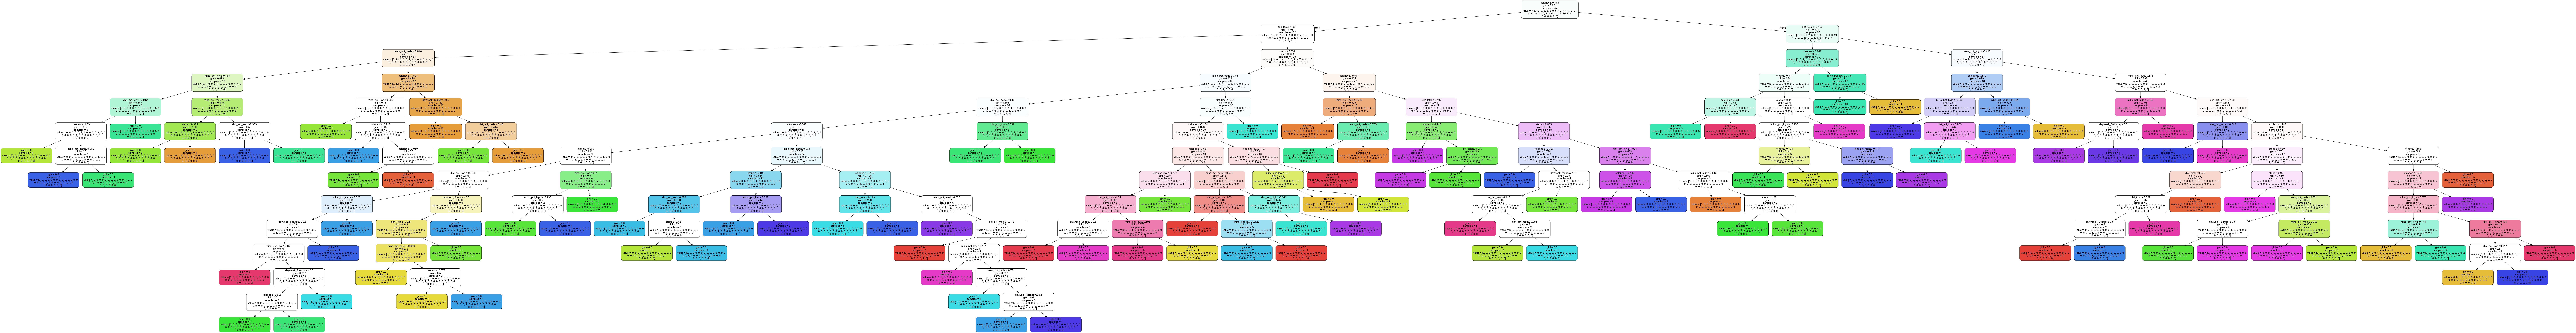

In [86]:
# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtr1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtc, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names=df_activity_2[features].columns
               )  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())